# Implementing K-Means Clustering
In this notebook, we design a simple implementation of K-means clustering and test it on some synthetic data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

# Synthetic Data
The **make_blobs** function defaults to generating 500 observations from a mixture of three Gaussians in $\mathbb{R}^2$ with mixing weights $\pi = [0.2, 0.5, 0.3]$ and means $\mu$ and covariances $\Sigma$ as follows:
$$\mu_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$$

$$\mu_2 = \begin{bmatrix} 3 \\ 0 \end{bmatrix}, \Sigma_2 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$$

$$\mu_3 = \begin{bmatrix} 0 \\ 3 \end{bmatrix}, \Sigma_3 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$$

In [3]:
def make_blobs(n_instances=500,
               mixing_weights=np.array([0.2, 0.5, 0.3]),
               means=[np.array([0,0]), np.array([3,0]), np.array([0,3])],
               covariances=[np.eye(2)]*3):
    
    # convert weights to integers indicating size of each class
    n_observations = np.round(n_instances * mixing_weights).astype(int)
    
    X = list()
    y = list()
    for label, n_obs in enumerate(n_observations):
        data = np.random.multivariate_normal(mean=means[label],
                                             cov=covariances[label],
                                             size=n_obs)
        X.append(data)
        y.extend([label] * n_obs)
    X = np.row_stack(X)
    y = np.array(y)
    return X, y 

# K-Means Clustering
K-means is the simplest and most fundamental clustering algorithm. Given data $x_1, x_2, ..., x_n$, let $c_i$ be the index of cluster $x_i$ is assigned to and $\mu_k$ be the centroid of cluster $k$. K-means seeks to find cluster assignments $c$ and centroids $\mu$ that minimize the squared Euclidean distance between each point and the centroid of its assigned cluster. Formally, the K-means objective function can be written as:

$$\mu^*, c^* = \arg\min_{\mu, c} \sum_{i=1}^{n} \sum_{k=1}^{K}\mathbb{1}\{c_i=k\}\left\|x_i - \mu_k\right\|^2$$

Because the objective function is **non-convex**, K-means is only able to find locally optimal values for $\mu^*$ and $c^*$. It does so via **coordinate descent**, whereby we first fix $\mu$ to find the optimal values for $c$ and then fix $c$ to find the optimal values for $\mu$.

K-means performs the following until $c$ and $\mu$ stop changing:
1. Update each $c_i$:
$$c_i = \arg\min_k \left\|x_i - \mu_k\right\|^2$$
2. Update each $\mu_k$:
$$\mu_k = \frac{\sum_{i=1}^{n}\mathbb{1}\{c_i = k\}x_i}{\sum_{i=1}^{n}\mathbb{1}\{c_i=k\}}$$

The model below implements K-means accordingly. It makes use of the following fact to calculate squared Euclidean distances in a vectorized manner for fast performance:

$$\left\|x_i - \mu_k \right\|^2 = x_i^Tx_i - 2x_i^T\mu_k + \mu_k^T\mu_k$$

In [4]:
class KMeans():
    
    def __init__(self, n_clusters=3, n_iter=20):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        
    def fit(self, X, y=None):
        # get dimensionality of data
        n_features = X.shape[1]
        
        # randomly initialize cluster centers
        centroids = [np.random.rand(n_features) for i in range(self.n_clusters)]
        self.centroids = np.array(centroids)
        self.loss = list()
        
        for i in range(self.n_iter):
            # for each observation, calculate its distance to all three centroids
            
            # n_observations x 1
            X_squared_norms = (np.linalg.norm(X, axis=1) ** 2).reshape(-1,1)
            
            # 1 X n_clusters
            C_squared_norms = (np.linalg.norm(self.centroids, axis=1) ** 2).reshape(1,-1)
            
            # n_observations x n_clusters
            interaction = self.centroids.dot(X.T).T
            
            # n_observations x n_clusters
            distances = X_squared_norms - 2 * interaction + C_squared_norms
            
            # generate cluster assignments
            self.labels = np.argmin(distances, axis=1)
            
            # based on cluster assignments, calculate new centroids and partial loss
            partial_losses = list()
            for k in range(self.n_clusters):
                
                # update cluster center
                self.centroids[k,:] = X[self.labels==k].mean(axis=0)
                
                # calculate partial loss
                differences = X[self.labels==k] - self.centroids[k,:]
                distances = np.linalg.norm(differences, axis=1) ** 2
                partial_losses.append(distances.sum())
                
            self.loss.append(np.sum(partial_losses))

        return self
    
    def transform(self, X):
        return self.labels
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
        

For $K = 2, 3, 4, 5$, we plot the value of the K-means objective function per iteration for 20 iterations. The greater the number of clusters, the lower the loss. Intuitively, this makes sense as the loss would be reduced to $0$ when the number of clusters equals the number of samples.

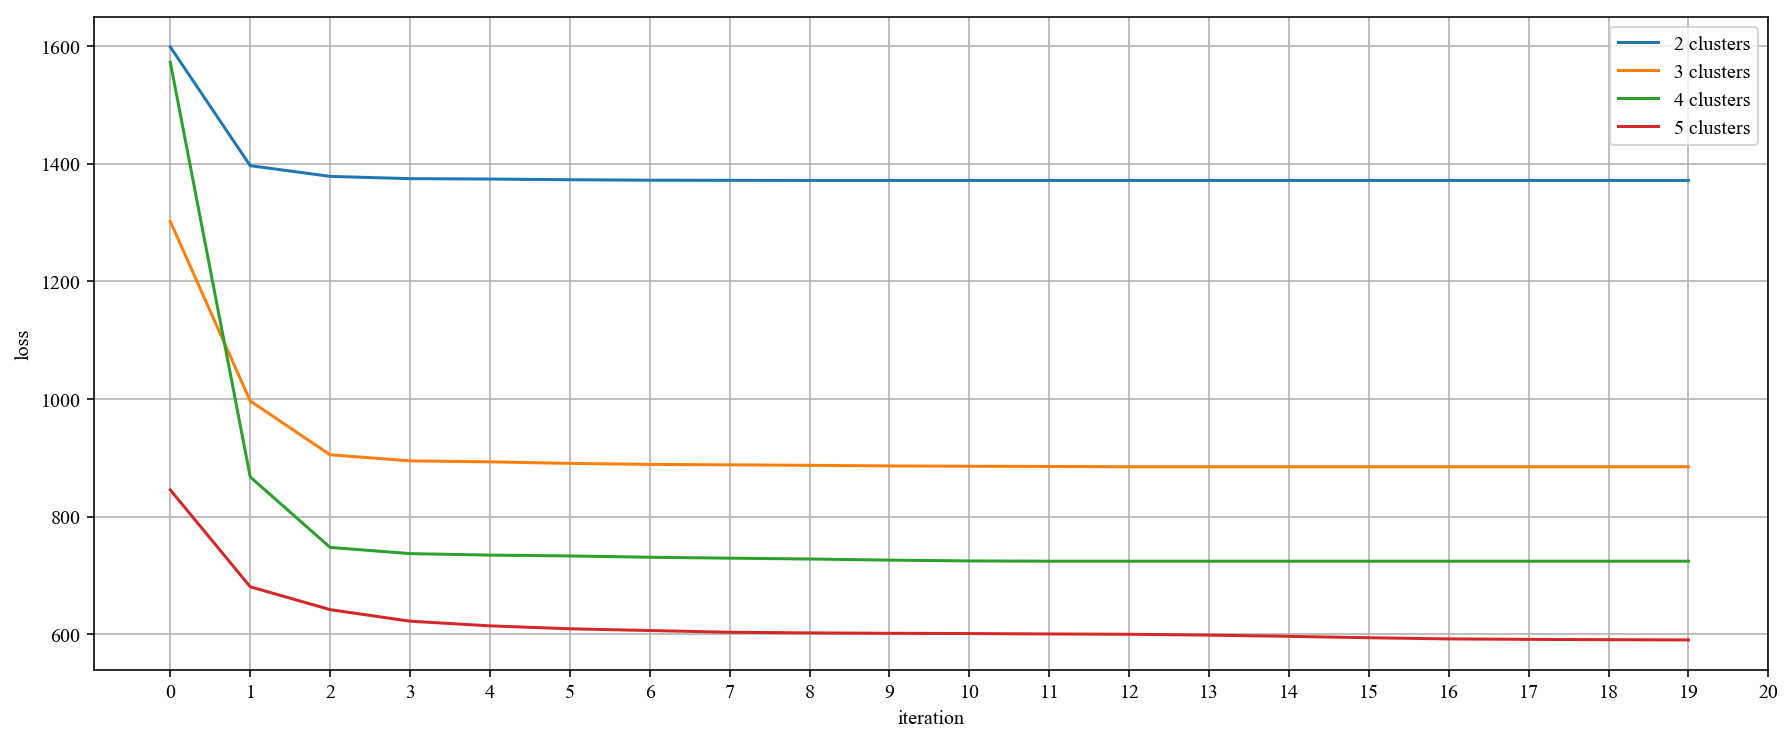

In [15]:
X, y = make_blobs()

ks = range(2,6)
plt.figure(figsize = (15,6))

for k in ks:
    losses = KMeans(n_clusters=k).fit(X).loss
    plt.plot(losses, label='{} clusters'.format(k))

plt.legend()
plt.grid(True)
plt.xticks(range(21))
plt.xlabel('iteration')
plt.ylabel('loss');

For $K = 2, 3, 4, 5$, we plot the $500$ data points and show their corresponding cluster.

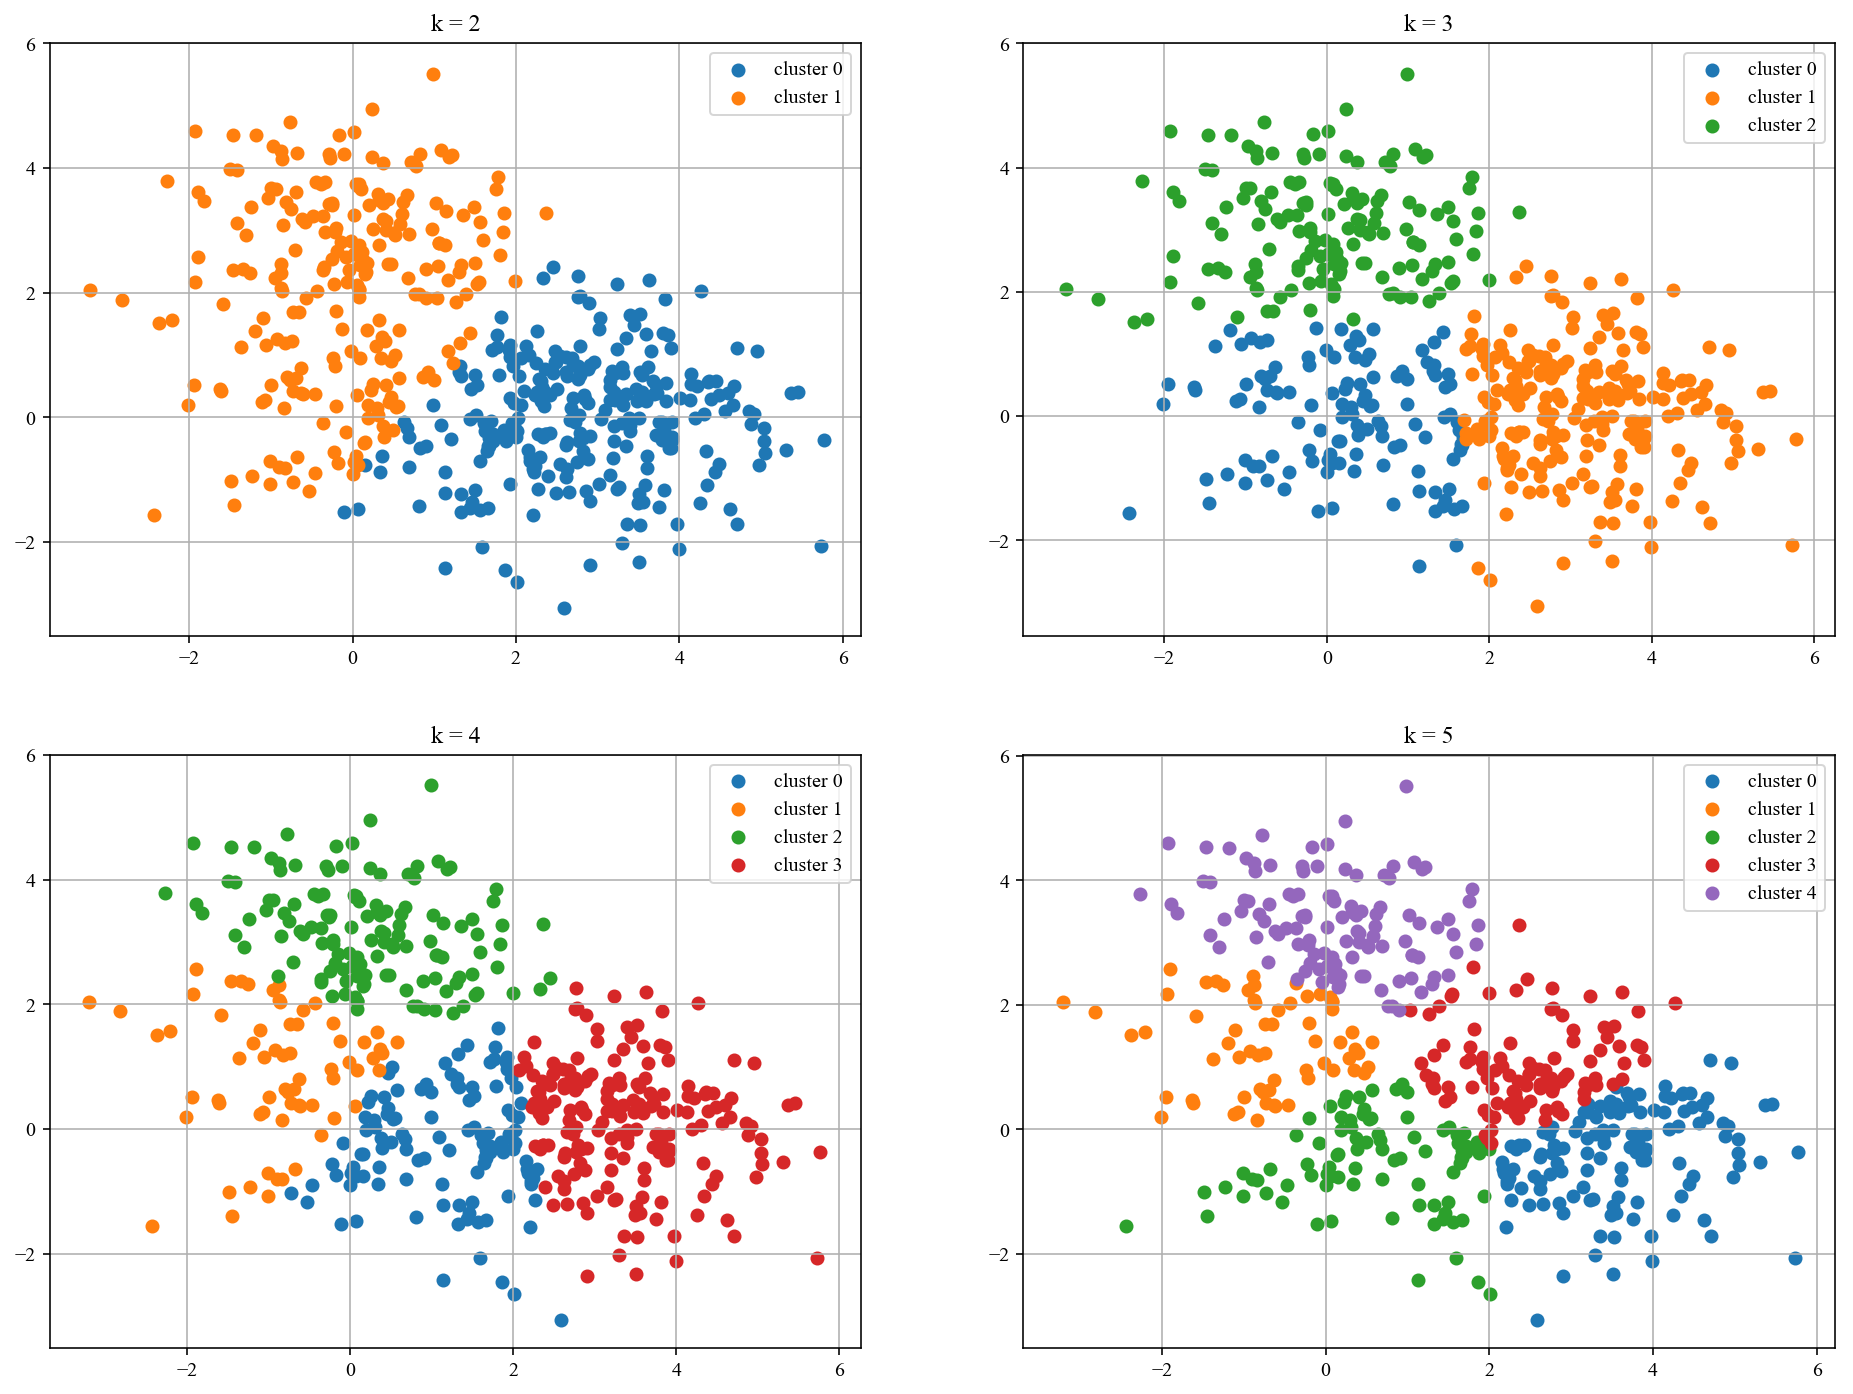

In [19]:
ks = list(range(2,6))
labels_list = [KMeans(n_clusters=k).fit_transform(X) for k in ks]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
for ax, labels, k in zip(axes, labels_list, ks):
    for label in set(labels):
        X_filtered = X[labels == label]
        ax.scatter(X_filtered[:,0], X_filtered[:,1],
                   label='cluster {}'.format(label))
    ax.grid(True)
    ax.set(title = 'k = {}'.format(k))
    ax.legend()